# Tutorial to create a logo #

In [6]:
%load_ext autoreload
%autoreload 2
from Bio import SeqIO
from evoaug_tf import evoaug, augment
from src.deepExplain_tool import getDeepExplainerBackground, deepExplain, plotResults
from src.diff_expression_model import load_model, get_siamese_model
import numpy as np
import importlib
import pickle
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Retrieve the siamese model based on the weight of Helder

In [7]:

model_path = "./data/model_single.json"
weights_path = "./data/weights_single.h5"

augment_list = [
	augment.RandomRC(rc_prob=0.5),
	augment.RandomInsertionBatch(insert_min=0, insert_max=20),
	augment.RandomDeletion(delete_min=0, delete_max=30),
	augment.RandomTranslocationBatch(shift_min=0, shift_max=20),
	augment.RandomMutation(mutate_frac=0.05),
	augment.RandomNoise()
]

model = load_model(model_path, weights_path)
siamese_model = get_siamese_model(model)


2024-07-03 10:50:56.843509: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/shared/apps/x86_64/dependencies_rl9:/software/shared/apps/x86_64/git/2.13.1/lib64/
2024-07-03 10:50:56.843823: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-07-03 10:50:56.843976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cyclone4.psblocal): /proc/driver/nvidia/version does not exist



Loaded model from disk


Generate a background based on the sequences provided by Helder

In [8]:
bg_path = "./data/background_100samples.pkl"
with open(bg_path, 'rb') as f:
    background_data = pickle.load(f)

# Conver to numpy
np_bg = np.array(background_data)

# Remove axis of dimension 1
np_bg = np.squeeze(np_bg)

# Convert to float 64, to be compatible with deepExplain
np_bg = np.float64(np_bg)

background = getDeepExplainerBackground(background_samples=np_bg, shuffle=False, post_hoc_conjoining=True)

The genes for which we want to create a logo

In [9]:
gene_ids_to_explain_klaas = [
	'AT1G21400::Chr1:7493755-7494375(+)',
	'AT3G52780::Chr3:19563207-19563827(-)',
	'AT1G79700::Chr1:29990993-29991613(-)',
	'AT2G20560::Chr2:8849372-8849650(-)',
	'AT1G79700::Chr1:29993088-29993321(-)']

Retrieve the sequences

In [10]:
sequence_list = []
gene_id_list = []

for chunk in range(1,201):
	fasta_path = f"/group/transreg/heopd/dlpipe/code/Sander/data/intron_620_chunks/introns_slide_pad_620.fasta_c{chunk}"
	fasta_sequences = SeqIO.parse(open(fasta_path),'fasta')
	for fasta in fasta_sequences:
		name, sequence = fasta.id, str(fasta.seq)
		if name in gene_ids_to_explain_klaas:
			gene_id_list.append(name)
			sequence_list.append(sequence)

One hot encode the sequences and creat ethe reverse compliment

In [32]:
ohe_list = []
ohe_rc_list = []
for sequence in sequence_list:
	ohe_seq = []
	ohe_rc_seq = []
	for i in sequence:
		if i == 'A':
			ohe_seq.append([1., 0., 0., 0.])
			ohe_rc_seq.append([0., 0., 0., 1.])
		elif i == 'C':
			ohe_seq.append([0., 1., 0., 0.])
			ohe_rc_seq.append([0., 0., 1., 0.])
		elif i == 'G':
			ohe_seq.append([0., 0., 1., 0.])
			ohe_rc_seq.append([0., 1., 0., 0.])
		elif i == 'T':
			ohe_seq.append([0., 0., 0., 1.])
			ohe_rc_seq.append([1., 0., 0., 0.])
		else:
			ohe_seq.append([0., 0., 0., 0.])
			ohe_rc_seq.append([0., 0., 0., 0.])
	ohe_list.append(ohe_seq)
	ohe_rc_list.append(list(reversed(ohe_rc_seq)))
ohe_np = np.array(ohe_list)
ohe_rc_np = np.array(ohe_rc_list)

np_deepexplain_samples = np.stack((ohe_np, ohe_rc_np))

In [35]:
shap_values = deepExplain(samples=np_deepexplain_samples,
                          loaded_model=siamese_model, 
                          bg=background, 
                          post_hoc_conjoining=True, 
                          augment_list=augment_list, 
                          pad_background=True, 
                          pad_samples=False,
                          show_evo_aug_padding=True)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


not flipped


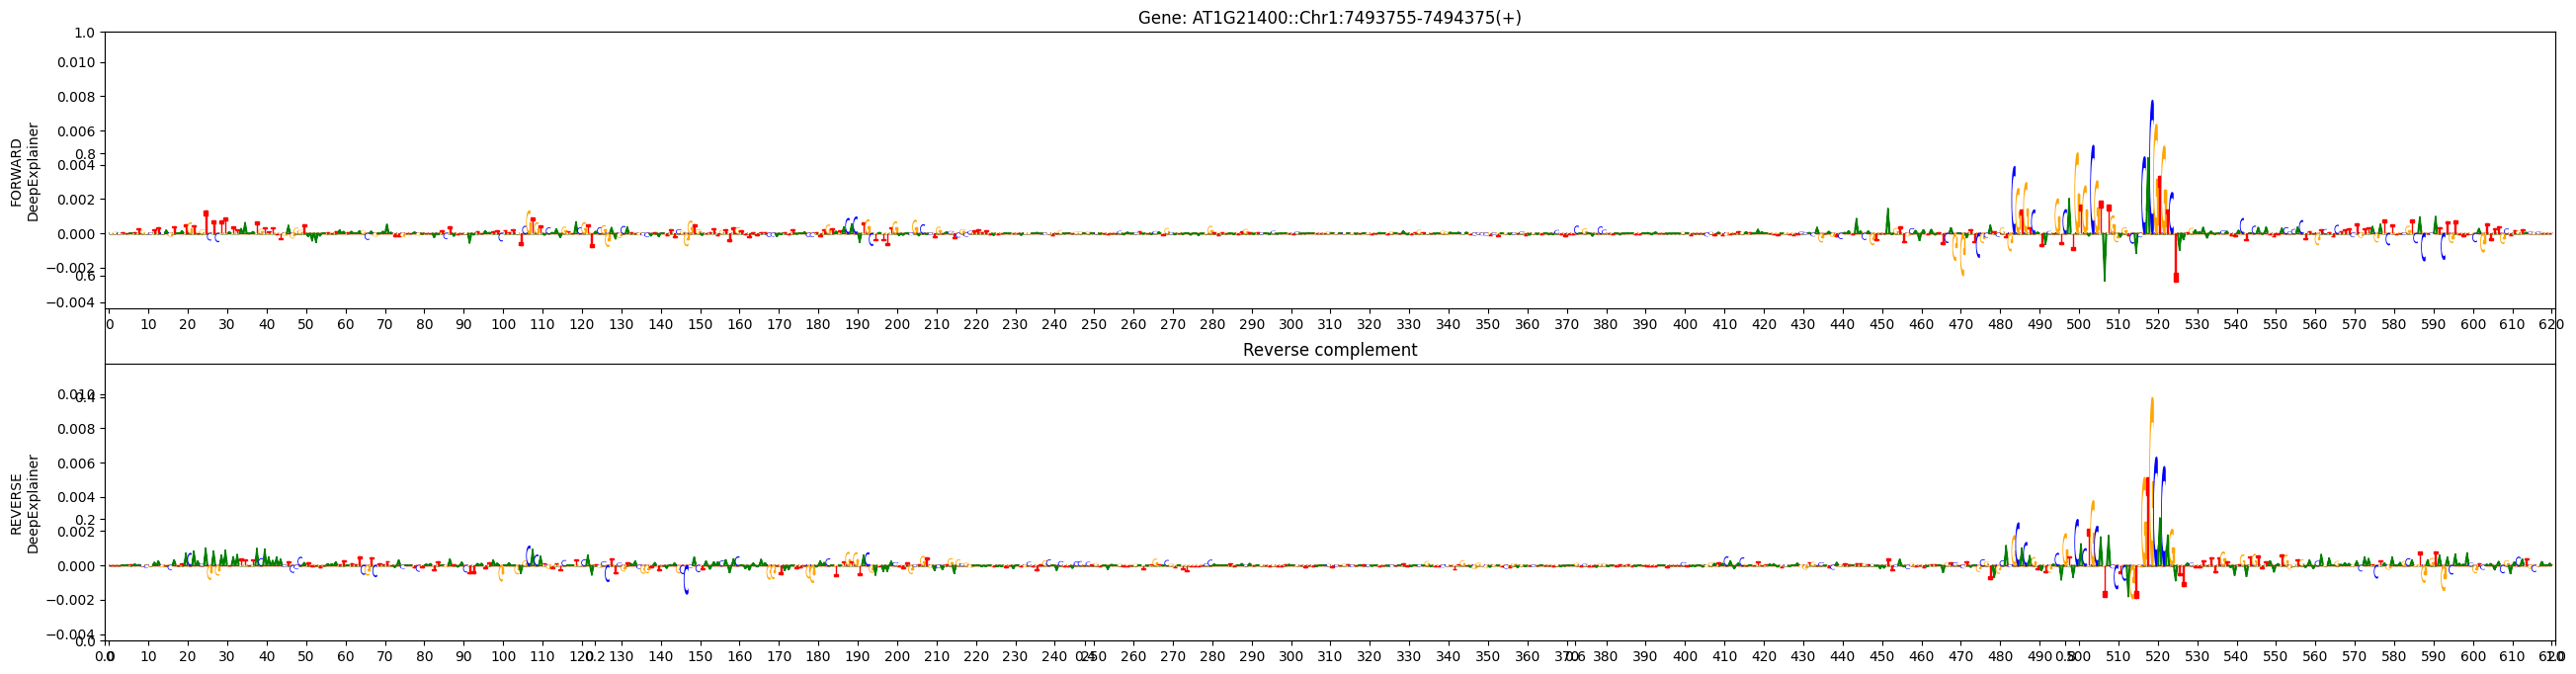

In [50]:
plotResults(shap_values=shap_values, 
            samples=np_deepexplain_samples, 
            post_hoc_conjoining=True, 
            gene_ids=gene_ids_to_explain_klaas,
            in_silico_mut=False,
            model=siamese_model
)